# Modeling spike data with `multidms.jaxmodels`

In [1]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
df = pd.read_csv("training_functional_scores_no_agg.csv", keep_default_na=False)

df.query("replicate == 1", inplace=True)

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

df.query("(pre_count >= 50) & (post_count >= 1)", inplace=True)

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,Delta,1,,0,5027212,4967837
1,Delta,1,A1015D,1,978,291
2,Delta,1,A1015D E1188Q,2,796,268
3,Delta,1,A1015D T1027S,2,841,63
5,Delta,1,A1015T,1,1051,441
...,...,...,...,...,...,...
174468,Omicron_BA2,1,Y91H T108L D287G A701T S939H,5,527,3
174469,Omicron_BA2,1,Y91N D138N Q474E,3,217,26
174470,Omicron_BA2,1,Y91N N603I S1252Y,3,792,160
174471,Omicron_BA2,1,Y91T N137T F375T F562L Q804H,5,627,13


Our model doesn't make sense for nonsense variants. We truncate, and then filter no missense before first nonsense.

In [3]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

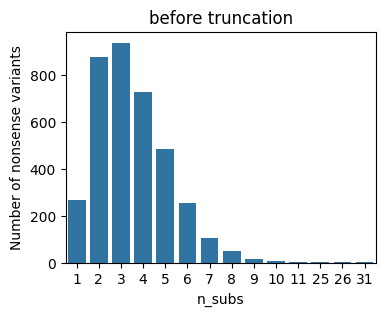

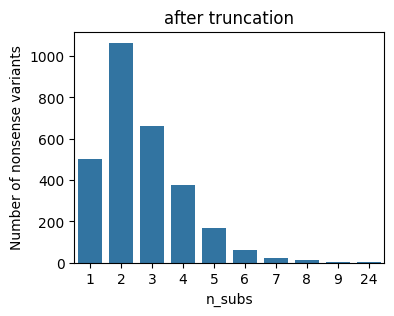

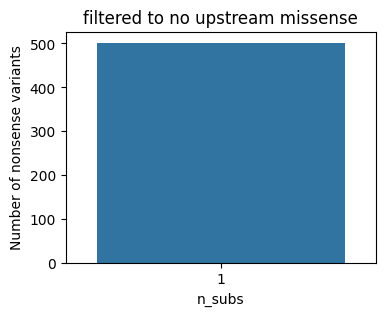

In [4]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

df = df.apply(truncate_nonsense, axis=1)
# re-aggregate identical variants
df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("after truncation")
plt.show()

df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("filtered to no upstream missense")
plt.show()

Functional scores

In [5]:
pseudocount = 0.5
df["func_score"] = np.log2(df["post_count"] + pseudocount) - np.log2(df["pre_count"] + pseudocount)

def group_wt_ref(df_group):
    wts = df_group.query("aa_substitutions == ''")
    assert wts.shape[0] == 1, wts
    df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
    return df_group

df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

In [6]:
df.shape

(154469, 7)

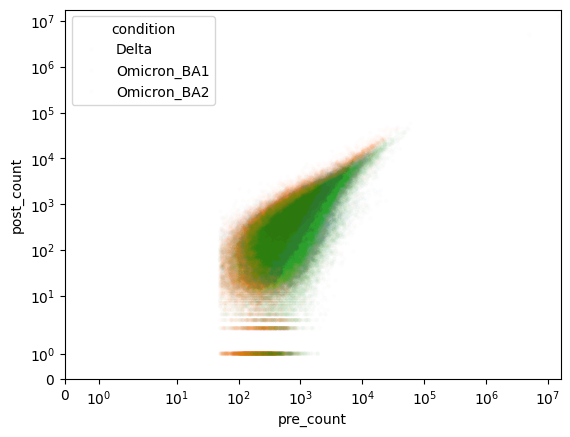

In [7]:
sns.scatterplot(x=df.pre_count.astype(float), y=df.post_count.astype(float), hue=df.condition, s=10, alpha=0.01)
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlim(0, None) 
plt.ylim(0, None)
plt.show()

In [8]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference="Omicron_BA1",
)

In [9]:
data_sets = {d: multidms.jaxmodels.Data(multidms_data, d) for d in multidms_data.conditions}

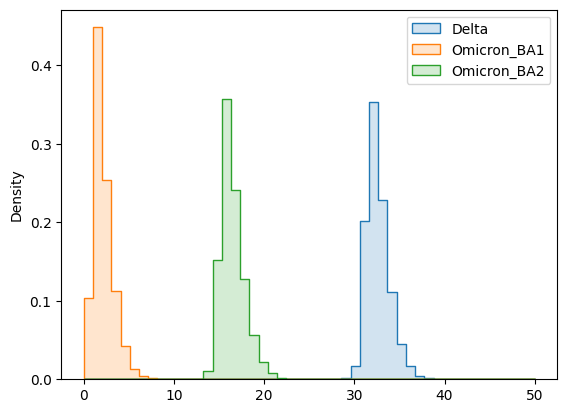

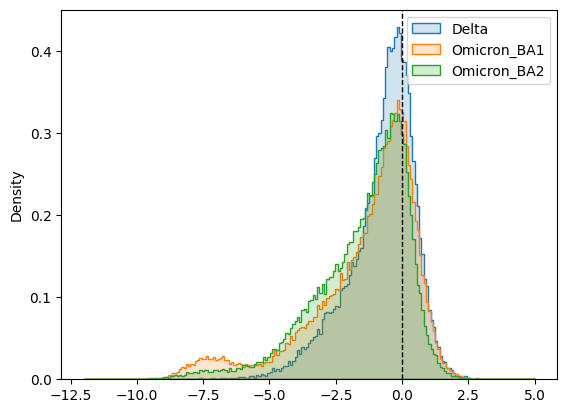

In [10]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

In [11]:
model, state = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg_α=1e-2,
    l2reg=1e-5,
    fusionreg=2e-3,
    opt_kwargs=dict(tol=1e-3, maxiter=1000, verbose=True),
)

INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 50.01120081910116 Stepsize:0.125 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 19.831438997961936 Stepsize:0.0625 
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 12.45660887382843 Stepsize:0.03125 
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 3.8321270918616 Stepsize:0.0625 
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Iterates (stop. crit.): 1.6638709204756463 Stepsize:0.125 
INFO: jaxopt.ProximalGradient: Iter: 6 Distance btw Iterates (stop. crit.): 4.51089077262668 Stepsize:0.03125 
INFO: jaxopt.ProximalGradient: Iter: 7 Distance btw Iterates (stop. crit.): 2.302091980305965 Stepsize:0.0625 
INFO: jaxopt.ProximalGradient: Iter: 8 Distance btw Iterates (stop. crit.): 1.7670768362073992 Stepsize:0.125 
INFO: jaxopt.ProximalGradient: Iter: 9 Distance btw Iterates (stop. crit.): 5.919287581474242 Stepsize:0.03125 
I

In [18]:
state

ProxGradState(iter_num=Array(1000, dtype=int64, weak_type=True), stepsize=Array(0.25, dtype=float64), error=Array(0.6820713, dtype=float64), aux=None, velocity=Model(
  φ={
    'Delta':
    Latent(β0=f64[], β=f64[10584]),
    'Omicron_BA1':
    Latent(β0=f64[], β=f64[10584]),
    'Omicron_BA2':
    Latent(β0=f64[], β=f64[10584])
  },
  α={'Delta': f64[], 'Omicron_BA1': f64[], 'Omicron_BA2': f64[]},
  reference_condition='Omicron_BA1'
), t=Array(502.55144676, dtype=float64, weak_type=True))

In [19]:
model.α

{'Delta': Array(4.67065658, dtype=float64),
 'Omicron_BA1': Array(5.51137766, dtype=float64),
 'Omicron_BA2': Array(5.33016172, dtype=float64)}

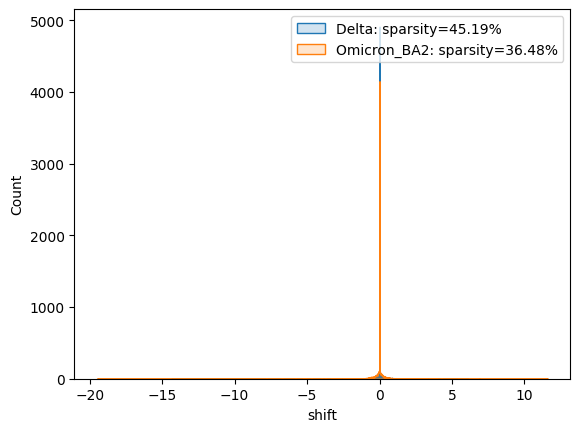

In [20]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            label=f"{d}: sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shift")
plt.show()

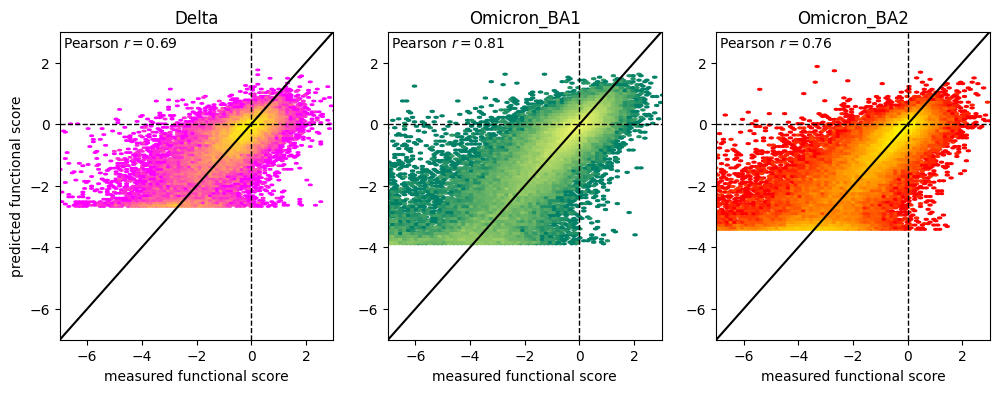

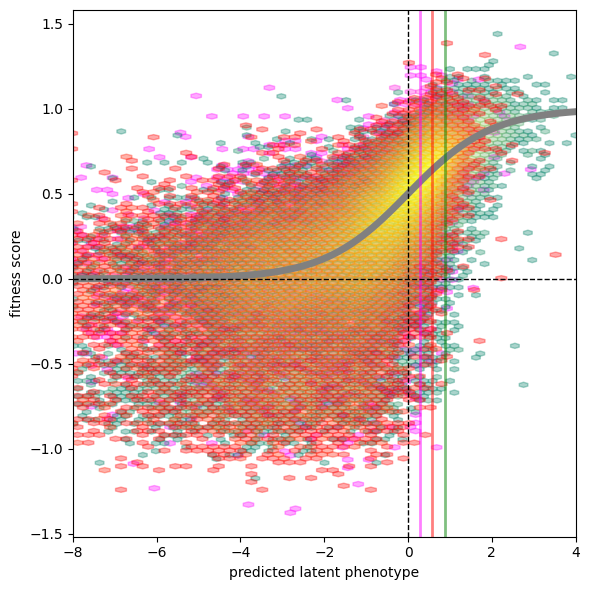

In [21]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $r={scipy.stats.pearsonr(y, y_pred).statistic:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-7, 3)
    plt.ylim(-7, 3)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()


plt.figure(figsize=(6, 6))
φ_grid = np.linspace(-8, 4, 100)
plt.plot(φ_grid, model.g(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.g(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", alpha=1/3)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
plt.xlim(φ_grid[0], φ_grid[-1])
# plt.ylim(-12, 3)
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
plt.tight_layout()
plt.show()

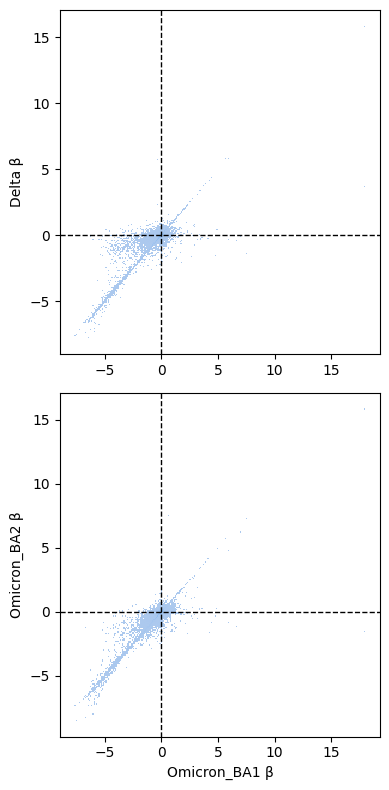

In [22]:
plt.figure(figsize=(4, 8))

plt.subplot(211)
ax = sns.histplot(x=model.φ["Omicron_BA1"].β, y=model.φ["Delta"].β)
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.ylabel("Delta β")

plt.subplot(212, sharex=ax)
sns.histplot(x=model.φ["Omicron_BA1"].β, y=model.φ["Omicron_BA2"].β)
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.xlabel("Omicron_BA1 β")
plt.ylabel("Omicron_BA2 β")

plt.tight_layout()
plt.show()

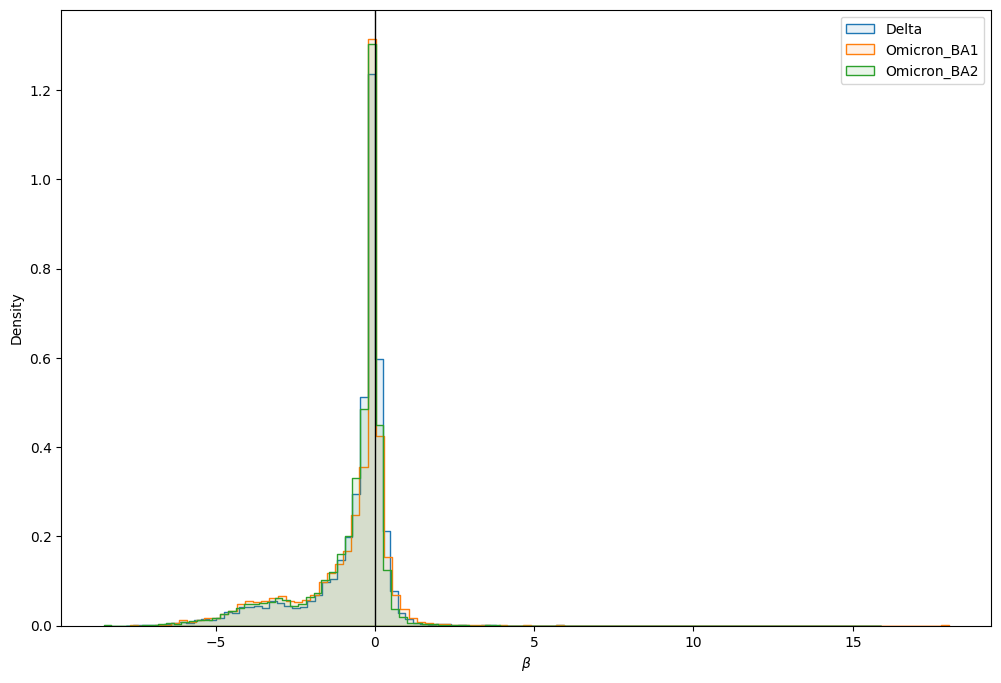

In [23]:
plt.figure(figsize=(12, 8))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()